In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")
import environments

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
import stats

from tqdm import tqdm
import analysis_tools

In [2]:
model_name = f"../models/al1_10_l2_0"
path = f"../models/{model_name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN")

## Elongation experiment

In [3]:
sequence = ["square", "square"]
a = np.linspace(-1, 1, 32)
b = np.linspace(-1, 1, 32)
bins =  [[a, b] for i in range(len(sequence))]# extra bins for rectangular environment, x-direction!

In [4]:
x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = 10000, context = params["context"]) # create dataset

In [5]:
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds = model.inference(dataset)

burn_in = 500
ps = ps[:,burn_in:]
r = r[:,burn_in:]

In [6]:
p_ratemaps = stats.population_vector_ratemaps(ps, r, bins, smooth = False)

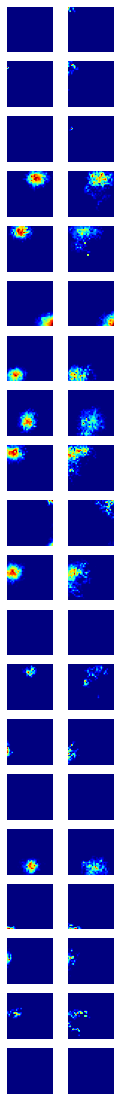

In [7]:
analysis_tools.plot_sequence(p_ratemaps, show_units = 20);

In [8]:
# And to look for field splitting, we stretch the box even further!

In [9]:
scale = 2.5
env = environments.Environments()
env.envs["rectangle"]= env.envs["rectangle"]*np.array([scale, 1])[None,None]
sequence = ["square", "rectangle"]

a = np.linspace(-1.5*scale, 1.5*scale, int(1.5*scale*32))
b = np.linspace(-1, 1, 32)
stretch_bins = [[a,a] for i in range(len(sequence))] # extra bins for rectangular environment, x-direction!

stretch_bins = [32, 32]

In [10]:
# swap context signals
a = []
b = []
for i in tqdm(range(50)):
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = 5000, context = params["context"], env = env) # create dataset
    backup_square = torch.clone(x[0][0,:,2:])
    x[0][-1,:,2:] = backup_square

    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gs, ps, centers, preds = model.inference(dataset)
    a.append(ps)
    b.append(r)

100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


In [17]:
aa = np.concatenate(a, axis = 1)
rr = np.concatenate(b, axis = 1)

p_ratemaps = stats.population_vector_ratemaps(aa, rr, stretch_bins, smooth = True)

aa.shape, rr.shape, p_ratemaps.shape

((2, 250000, 100), (2, 250000, 2), (2, 100, 32, 32))

In [12]:
#p_ratemaps = stats.population_vector_ratemaps(ps, r, stretch_bins, smooth = False)
#g_ratemaps = stats.population_vector_ratemaps(gs, r, stretch_bins, smooth = False)

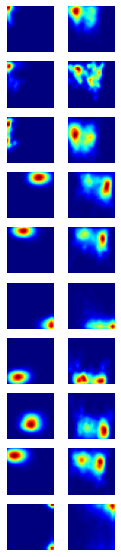

In [19]:
analysis_tools.plot_sequence(p_ratemaps, show_units =10);
#plt.subplots_adjust(hspace = -0.99, wspace = 0.01)